# ML-IMC data

## Analysis of ML-IMC training on LJ data

## The data is obtained with my Julia MC code that can be found here:

(https://github.com/mikhail-a-ivanov/ML-IMC)

In [3]:
using Plots
using Statistics
using BSON: @save, @load

include("src/distances.jl")
include("src/readLJ.jl")
include("src/ML-IMC.jl");

I have submitted four ML-IMC simulations on alkluster in total. Three of them use Momentum descent optimizer. I run 50 iterations with learning rate of 0.05 and momentum coefficients of 0.9, 0.75 and 0.5. For reference I run 100 iterations of standard gradient descent with 100 iterations and learning rate of 0.01. All simulation run on 40 CPU cores with each running 10M steps for equilibration and 10M more steps for production. Production data is collected from each core and averaged.

In [4]:
HOME = pwd()

"/home/misha/ML-IMC-data"

# 1. Gradient descent

In [52]:
cd(HOME * "/learning/GD")

In [6]:
run(`cat LJML-init.in`)

# System
box           = 36.405 36.405 36.405 # Box vectors [Å]

# Conditions
temperature   = 95.0                 # [K]

# Monte Carlo parameters          
delta         = 0.75                 # Max displacement [Å]
steps         = 2E7                  # Total number of MC steps
Eqsteps       = 1E7                  # Equilibration MC steps

# Output control          
xyzout        = 0                    # XYZ output frequency
outfreq       = 1E3                  # Output frequency

# RDF parameters          
binWidth      = 0.025                # [Å]
Nbins         = 600                  # Number of bins

# Learning parameters
iters         = 100                  # Number of learning iterations
activation    = identity             # Activation function
optimizer     = Descent              # Optimizer (other options - Momentum)
rate          = 0.01                 # Learning rate

# Input files
xyzname       = mcLJ/mctraj-p001.xyz   # Input configuration file
rdfname       = mcLJ/rdf-me

Process(`cat LJML-init.in`, ProcessExited(0))

In [7]:
"""
function readloss(outname)

Reads loss data from ML-IMC output file
"""
function readloss(outname)
    lossdata = []
    file = open(outname, "r")
    lines = readlines(file)
    for line in lines
        if length(split(line)) > 0 && split(line)[1] == "Loss"
            append!(lossdata, parse(Float64, split(line)[end]))
        end
    end
    close(file)
    iters = 1:length(lossdata)
    return(iters, lossdata)
end;

In [53]:
itersGD, lossdataGD = readloss("p40.out");

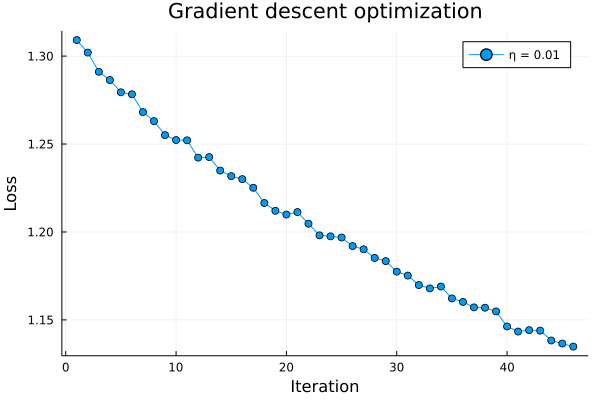

In [54]:
plot(itersGD, lossdataGD, title="Gradient descent optimization", label="η = 0.01", marker=(:dot))
xlabel!("Iteration")
ylabel!("Loss")

In [12]:
;pwd

/home/misha/ML-IMC-data/learning/GD


In [24]:
bins, rdfref, histref = readRDF("../mcLJ/rdf-mean-p40.dat")
histref ./= 500;


Reading reference data from ../mcLJ/rdf-mean-p40.dat...


In [27]:
"""
histname(rdfname)

Reads distance histogram file produced
by ML-IMC.jl
"""
function readhist(histname)
    file = open(histname, "r")
    println("\nReading histogram data from $(histname)...")
    lines = readlines(file)
    ncomments = 1
    nlines = length(lines) - ncomments
    bins = zeros(nlines)
    hist = zeros(nlines)
    for i in (1 + ncomments):length(lines)
        rdfline = split(lines[i])
        if length(rdfline) == 2
            bins[i - ncomments] = parse(Float64, rdfline[1])
            hist[i - ncomments] = parse(Float64, rdfline[2])
        end
    end
    return(bins, hist)
    close(file)
end;

In [28]:
bins, hist = readhist("histNN-iter-46.dat");


Reading histogram data from histNN-iter-46.dat...


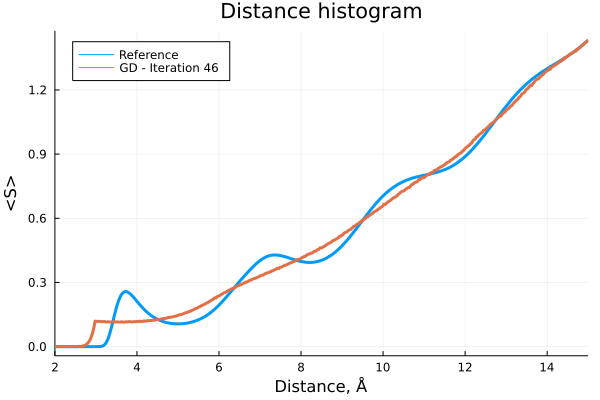

In [34]:
plot(bins, histref, xlim = (2, 15), linewidth=3, labels="Reference", title="Distance histogram", legend=:topleft)
plot!(bins, hist, xlim = (2, 15), linewidth=3, labels="GD - Iteration 46")
xlabel!("Distance, Å")
ylabel!("<S>")

In [35]:
@load "model-iter-46.bson" model

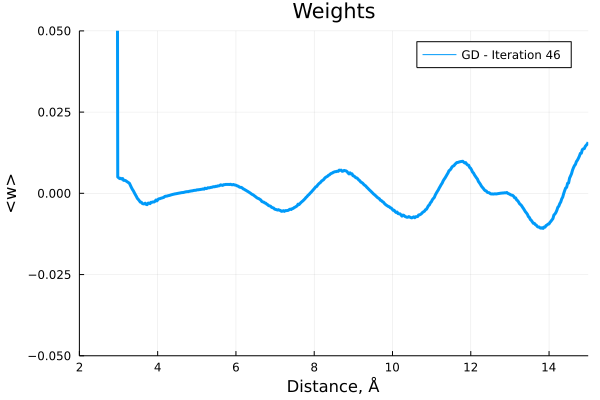

In [43]:
plot(bins, model.weight', title="Weights", label="GD - Iteration 46", xlim=(2, 15), ylim=(-0.05, 0.05), lw=3)
xlabel!("Distance, Å")
ylabel!("<w>")

# 2. Momentum descent (μ = 0.9)

In [63]:
cd(HOME * "/learning/MGD0.9")

In [46]:
run(`cat LJML-init.in`);

# System
box           = 36.405 36.405 36.405 # Box vectors [Å]

# Conditions
temperature   = 95.0                 # [K]

# Monte Carlo parameters          
delta         = 0.75                 # Max displacement [Å]
steps         = 2E7                  # Total number of MC steps
Eqsteps       = 1E7                  # Equilibration MC steps

# Output control          
xyzout        = 0                    # XYZ output frequency
outfreq       = 1E3                  # Output frequency

# RDF parameters          
binWidth      = 0.025                # [Å]
Nbins         = 600                  # Number of bins

# Learning parameters
iters         = 50                   # Number of learning iterations
activation    = identity             # Activation function
optimizer     = Momentum             # Optimizer (other options - Descent)
rate          = 0.05                 # Learning rate
momentum      = 0.9                  # Momentum coefficient

# Input files
xyzname       = mcLJ/mctraj-p001.x

In [64]:
itersMGD09, lossdataMGD09 = readloss("p40.out");

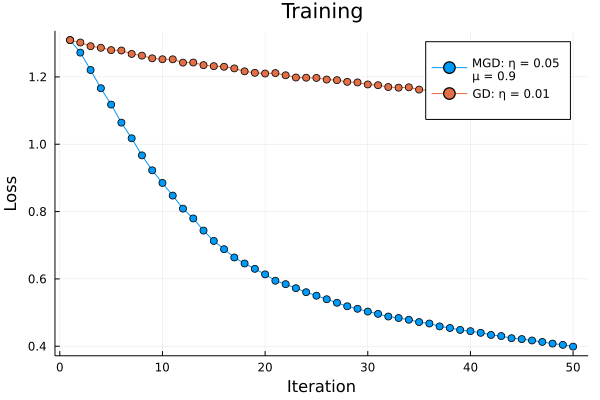

In [65]:
plot(itersMGD09, lossdataMGD09, title="Training", 
    label="MGD: η = 0.05\nμ = 0.9", marker=(:dot))
plot!(itersGD, lossdataGD, label="GD: η = 0.01", marker=(:dot))
xlabel!("Iteration")
ylabel!("Loss")

In [66]:
bins, hist = readhist("histNN-iter-50.dat");


Reading histogram data from histNN-iter-50.dat...


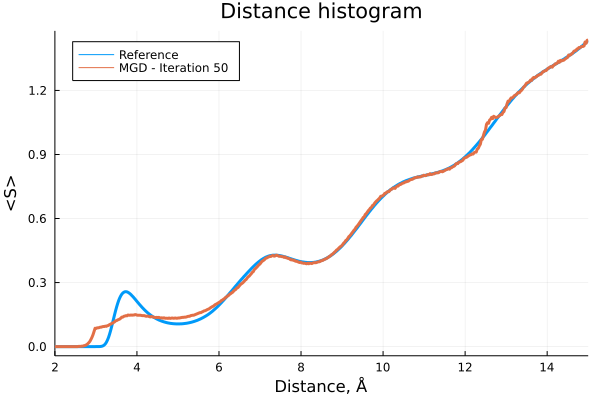

In [67]:
plot(bins, histref, xlim = (2, 15), linewidth=3, labels="Reference", title="Distance histogram", legend=:topleft)
plot!(bins, hist, xlim = (2, 15), linewidth=3, labels="MGD - Iteration 50")
xlabel!("Distance, Å")
ylabel!("<S>")

This is the best so far!

In [68]:
@load "model-iter-50.bson" model

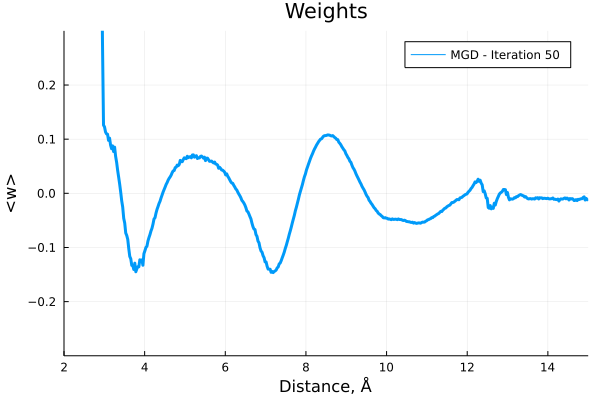

In [71]:
plot(bins, model.weight', title="Weights", label="MGD - Iteration 50", xlim=(2, 15), ylim=(-0.3, 0.3), lw=3)
xlabel!("Distance, Å")
ylabel!("<w>")

# 3. Momentum descent (μ = 0.75)

In [87]:
cd(HOME * "/learning/MGD0.75")

In [73]:
run(`cat LJML-init.in`);

# System
box           = 36.405 36.405 36.405 # Box vectors [Å]

# Conditions
temperature   = 95.0                 # [K]

# Monte Carlo parameters          
delta         = 0.75                 # Max displacement [Å]
steps         = 2E7                  # Total number of MC steps
Eqsteps       = 1E7                  # Equilibration MC steps

# Output control          
xyzout        = 0                    # XYZ output frequency
outfreq       = 1E3                  # Output frequency

# RDF parameters          
binWidth      = 0.025                # [Å]
Nbins         = 600                  # Number of bins

# Learning parameters
iters         = 50                   # Number of learning iterations
activation    = identity             # Activation function
optimizer     = Momentum             # Optimizer (other options - Descent)
rate          = 0.05                 # Learning rate
momentum      = 0.75                 # Momentum coefficient

# Input files
xyzname       = mcLJ/mctraj-p001.x

In [74]:
itersMGD075, lossdataMGD075 = readloss("p40.out");

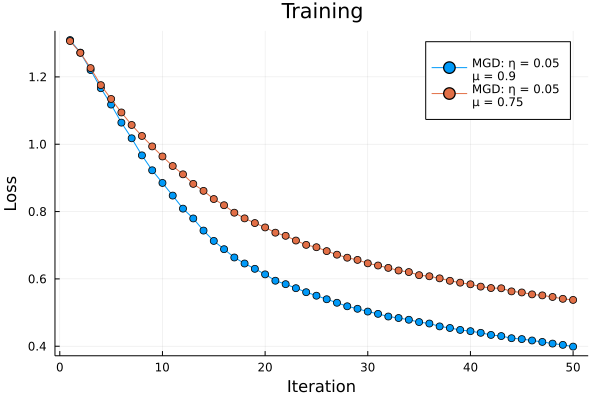

In [75]:
plot(itersMGD09, lossdataMGD09, title="Training", 
    label="MGD: η = 0.05\nμ = 0.9", marker=(:dot))
plot!(itersMGD075, lossdataMGD075, 
    label="MGD: η = 0.05\nμ = 0.75", marker=(:dot))
xlabel!("Iteration")
ylabel!("Loss")

In [76]:
bins, hist = readhist("histNN-iter-50.dat");


Reading histogram data from histNN-iter-50.dat...


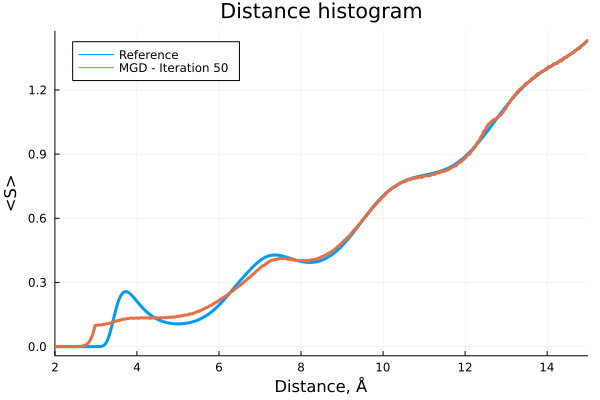

In [77]:
plot(bins, histref, xlim = (2, 15), linewidth=3, labels="Reference", title="Distance histogram", legend=:topleft)
plot!(bins, hist, xlim = (2, 15), linewidth=3, labels="MGD - Iteration 50")
xlabel!("Distance, Å")
ylabel!("<S>")

In [88]:
@load "model-iter-50.bson" model

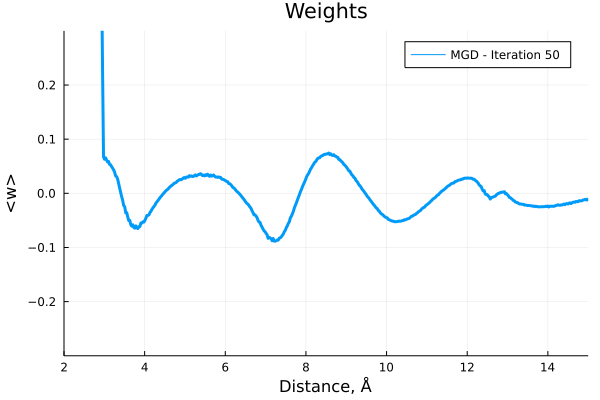

In [89]:
plot(bins, model.weight', title="Weights", label="MGD - Iteration 50", xlim=(2, 15), ylim=(-0.3, 0.3), lw=3)
xlabel!("Distance, Å")
ylabel!("<w>")

# 4. Momentum descent (μ = 0.5)

In [90]:
cd(HOME * "/learning/MGD0.5")

In [79]:
run(`cat LJML-init.in`);

# System
box           = 36.405 36.405 36.405 # Box vectors [Å]

# Conditions
temperature   = 95.0                 # [K]

# Monte Carlo parameters          
delta         = 0.75                 # Max displacement [Å]
steps         = 2E7                  # Total number of MC steps
Eqsteps       = 1E7                  # Equilibration MC steps

# Output control          
xyzout        = 0                    # XYZ output frequency
outfreq       = 1E3                  # Output frequency

# RDF parameters          
binWidth      = 0.025                # [Å]
Nbins         = 600                  # Number of bins

# Learning parameters
iters         = 50                   # Number of learning iterations
activation    = identity             # Activation function
optimizer     = Momentum             # Optimizer (other options - Descent)
rate          = 0.05                 # Learning rate
momentum      = 0.5                  # Momentum coefficient

# Input files
xyzname       = mcLJ/mctraj-p001.x

In [80]:
itersMGD05, lossdataMGD05 = readloss("p40.out");

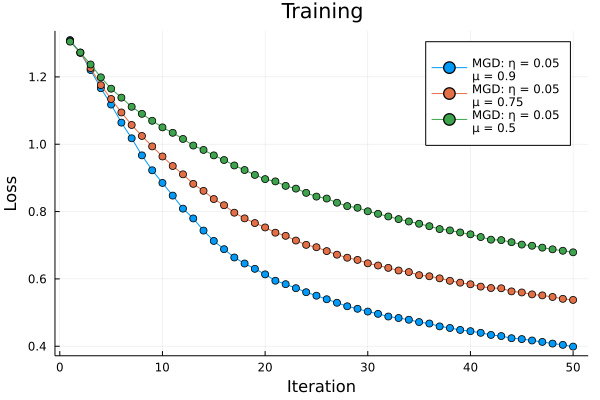

In [81]:
plot(itersMGD09, lossdataMGD09, title="Training", 
    label="MGD: η = 0.05\nμ = 0.9", marker=(:dot))
plot!(itersMGD075, lossdataMGD075, 
    label="MGD: η = 0.05\nμ = 0.75", marker=(:dot))
plot!(itersMGD05, lossdataMGD05, 
    label="MGD: η = 0.05\nμ = 0.5", marker=(:dot))
xlabel!("Iteration")
ylabel!("Loss")

In [82]:
bins, hist = readhist("histNN-iter-50.dat");


Reading histogram data from histNN-iter-50.dat...


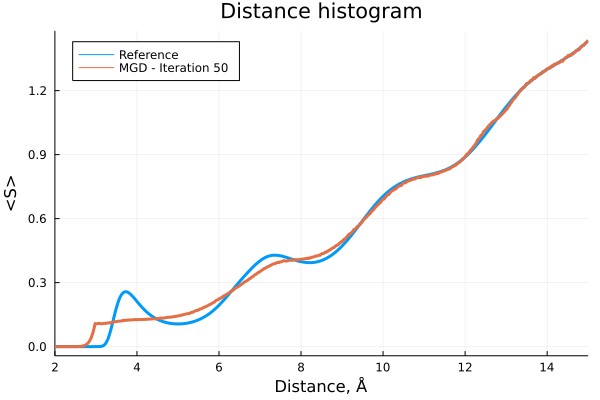

In [83]:
plot(bins, histref, xlim = (2, 15), linewidth=3, labels="Reference", title="Distance histogram", legend=:topleft)
plot!(bins, hist, xlim = (2, 15), linewidth=3, labels="MGD - Iteration 50")
xlabel!("Distance, Å")
ylabel!("<S>")

In [91]:
@load "model-iter-50.bson" model

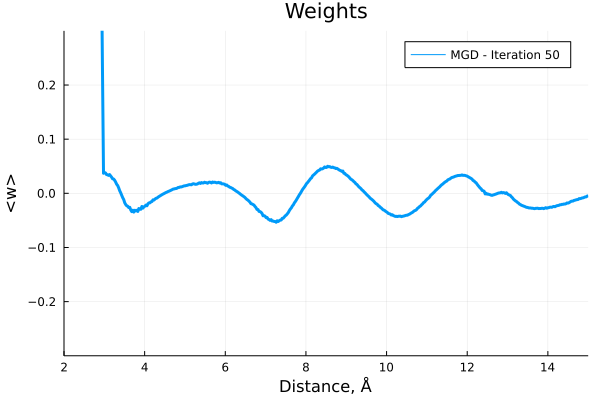

In [92]:
plot(bins, model.weight', title="Weights", label="MGD - Iteration 50", xlim=(2, 15), ylim=(-0.3, 0.3), lw=3)
xlabel!("Distance, Å")
ylabel!("<w>")

I need to continue training! I will increase learning rate to 0.1, keep experimenting with different momentum coefficients (0.9, 0.75 and 0.5) but will increase the number of iterations to 100.

I have submitted new MGD runs, new GD run with 0.1 learning rate is in the queue.